In [3]:
import sys
import os
# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from mendeleev import element
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

from scipy.interpolate import interp1d

tqdm.pandas()
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [4]:
def load_data(filename):
    # load data from a pkl file and derive formula and species columns from structure
    df = pd.read_pickle(filename)
    df['species'] = df['structure'].map(lambda x: list(set(x.get_chemical_symbols())))
    species = sorted(list(set(df['species'].sum())))

    #df['energies'] = df['energies'].apply(eval).apply(np.array)
    #df['absorption_coefficient'] = df['absorption_coefficient'].apply(eval).apply(np.array)
    #df['pdos'] = df['pdos'].apply(eval)

    return df, species

In [5]:
df,species = load_data("../dataset/openmx_data_20250319_152811.pkl")
df.head()

,folder,formula,structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_02,Im_10,Im_11,Im_12,Im_20,Im_21,Im_22,avg_re_trace,avg_im_trace,species
0,/global/cfs/cdirs/m225/angush/materialProject/...,Li4Se8Y4,"(Atom('Li', [2.83855, 0.0, 2.88335], index=0),...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.481281668892605, -1.3506806366681457e-09,...","[[[-1.0722568410351282e-17, -2.371619162135055...","[3.481281668892605, 3.4813019889159484, 3.4813...",...,"[1.3823342267093493e-17, 1.882754707806698e-12...","[-2.371619162135055e-18, -1.700559250283202e-1...","[-1.4324565125840434e-17, 0.000203386314985097...","[-6.400276971094875e-19, 1.187453653061564e-12...","[1.3823342267093493e-17, 1.882754707806698e-12...","[-6.400276971094875e-19, 1.187453653061564e-12...","[3.342549740214423e-18, 0.0001803350567406132,...","[3.4405690641171667, 3.44058861685612, 3.44064...","[-7.234861265325764e-18, 0.0001957028760583553...","[Li, Y, Se]"
1,/global/cfs/cdirs/m225/angush/materialProject/...,Mo3S2Se4,"(Atom('Mo', [1.636616366, 0.944882001641236, 3...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[5.126763705823415, -0.0036857171285808207, ...","[[[3.2316203633511406e-17, 4.065761255667405e-...","[5.126763705823415, 5.1268254576594545, 5.1270...",...,"[-9.092746101489361e-19, 1.2366187483073555e-0...","[4.065761255667405e-17, -1.0220638309201726e-0...","[2.017567602677919e-17, 0.0006175595714383959,...","[2.6785699480178126e-17, -7.1566796821889846e-...","[-9.092746101489361e-19, 1.2366187483073555e-0...","[2.6785699480178126e-17, -7.1566796821889846e-...","[5.356300432663947e-18, 0.00011878724682517897...","[4.321433518069999, 4.321478600797114, 4.32161...","[1.9282726697651513e-17, 0.0004517163617600133...","[Mo, S, Se]"
2,/global/cfs/cdirs/m225/angush/materialProject/...,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.7313146368871726, 7.054466462945285e-06, ...","[[[2.9669125906530276e-18, 2.117513176816877e-...","[1.7313146368871726, 1.7313217564659527, 1.731...",...,"[3.969580319788735e-18, 8.535424337320327e-10,...","[2.117513176816877e-18, 8.665236893517975e-10,...","[6.416846704309092e-18, 7.124085242430225e-05,...","[-1.0033425582785427e-17, 8.405343317085762e-1...","[3.969580319788735e-18, 8.535424337320327e-10,...","[-1.0033425582785427e-17, 8.405343317085762e-1...","[-6.4642318455671115e-18, 7.12408590969345e-05...","[1.7313150452437125, 1.7313221648231247, 1.731...","[9.731758164650026e-19, 7.124085259360446e-05,...","[Li, Nb, S]"
3,/global/cfs/cdirs/m225/angush/materialProject/...,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.2667371759234984, -3.486898178425755e-06,...","[[[-1.7162171221554744e-17, -4.972084285417574...","[3.2667371759234984, 3.266768077328808, 3.2668...",...,"[4.710222018194405e-18, 5.8322763388424595e-09...","[-4.972084285417574e-18, -2.2732976487244867e-...","[-5.209005378415435e-19, 0.0003101068789550751...","[-5.716867411329558e-18, 1.0499994209043163e-0...","[4.710222018194405e-18, 5.8322763388424595e-09...","[-5.716867411329558e-18, 1.0499994209043163e-0...","[-1.5461680231046413e-17, 0.000264086382651040...","[3.270700626888884, 3.270730008788789, 3.27081...","[-1.1048250663480898e-17, 0.000294768918248031...","[Cd, Zn, Se]"
4,/global/cfs/cdirs/m225/angush/materialProject/...,Al8Te12,"(Atom('Al', [5.408683744491139, 4.382650362, 3...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.57865600493003, -2.773634699822434e-08, 0...","[[[-2.370171074423322e-18, -5.455394216331598e...","[3.57865600493003, 3.5786781470220483, 3.57874...",...,"[3.360404376639049e-19, -5.867877074472817e-06...","[-5.455394216331598e-18, -1.2102901463658074e-...","[7.53575

/global/cfs/cdirs/m225/angush/materialProject/refined_structure/block_2025-03-06-19-02-20-105250/launcher_2025-03-06-19-09-56-445866


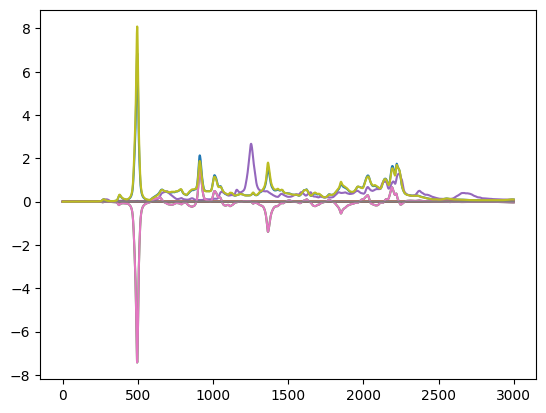

In [ ]:
# row = df[df["mp_id"]=="mp-1007665"].iloc[0]
# row = df[df["mp_id"]=="mp-1185959"].iloc[0]
row = df[df["mp_id"]=="mp-1067154"].iloc[0]
row = df[df["mp_id"]=="mp-1067154"].iloc[0]

print(row.folder)


for i in range(3):
    for j in range(3):
        plt.plot(row["imag_Permittivity_Matrices"][:,i,j])
plt.show()

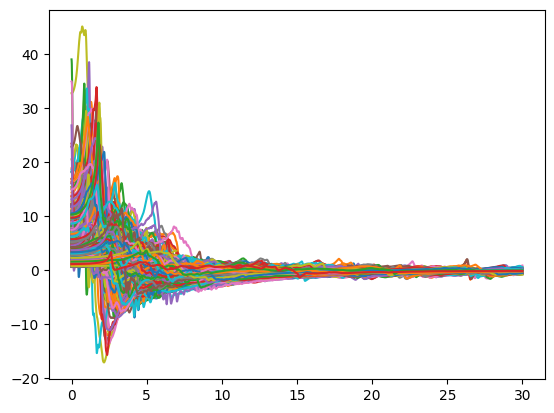

In [7]:
omega = df.iloc[0].omega

for i in range(len(df)):
    plt.plot(omega,df.avg_re_trace.iloc[i])
plt.show()

In [8]:
def process_atom(Z):
    """Process atomic properties for an element."""
    specie = Atom(Z)
    Z_mass = specie.mass
    Z_dipole = element(specie.symbol).dipole_polarizability or 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko
    return specie.symbol, Z - 1, Z_mass, Z_dipole, Z_radius

def save_or_load_onehot(save_path="../onehot_data"):
    # Define file paths
    type_onehot_path = os.path.join(save_path, "type_onehot.torch")
    mass_onehot_path = os.path.join(save_path, "mass_onehot.torch")
    dipole_onehot_path = os.path.join(save_path, "dipole_onehot.torch")
    radius_onehot_path = os.path.join(save_path, "radius_onehot.torch")
    encoding_path = os.path.join(save_path, "type_encoding.torch")

    # Check if data already exists
    if all(os.path.exists(path) for path in [type_onehot_path, mass_onehot_path, dipole_onehot_path, radius_onehot_path, encoding_path]):
        print("Loading existing data...")
        type_onehot = torch.load(type_onehot_path)
        mass_onehot = torch.load(mass_onehot_path)
        dipole_onehot = torch.load(dipole_onehot_path)
        radius_onehot = torch.load(radius_onehot_path)
        type_encoding = torch.load(encoding_path)
    else:
        print("Processing data...")
        type_encoding = {}
        specie_mass = []
        specie_dipole = []
        specie_radius = []

        for Z in tqdm(range(1, 119), desc="Processing Elements"):
            symbol, encoding, mass, dipole, radius = process_atom(Z)
            type_encoding[symbol] = encoding
            specie_mass.append(mass)
            specie_dipole.append(dipole)
            specie_radius.append(radius)

        # Convert to one-hot encodings
        type_onehot = torch.eye(len(type_encoding))
        mass_onehot = torch.diag(torch.tensor(specie_mass))
        dipole_onehot = torch.diag(torch.tensor(specie_dipole))
        radius_onehot = torch.diag(torch.tensor(specie_radius))

        # Save the data
        os.makedirs(save_path, exist_ok=True)
        torch.save(type_onehot, type_onehot_path)
        torch.save(mass_onehot, mass_onehot_path)
        torch.save(dipole_onehot, dipole_onehot_path)
        torch.save(radius_onehot, radius_onehot_path)
        torch.save(type_encoding, encoding_path)
        print("Data saved!")

    return type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding

# Run the function
type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

Loading existing data...


# Down sampling 

In [18]:
energy_min = 0.0 #Unit of energy in eV
energy_max = 20 #Unit of energy in eV
nstep = 201 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
def interpolate(row, column):
    interp = interp1d(row['omega'], row[column], kind='linear', fill_value=0, bounds_error=False)
    new_y = interp(new_x)
    return new_y

df['energies_interp'] = df.apply(lambda x: new_x, axis=1)
df['imag_dielectric_interp'] = df.apply(lambda row: interpolate(row, 'avg_im_trace'), axis=1)

tmp = np.array([df.iloc[i]['imag_dielectric_interp'] for i in range(len(df))])
scale_data = np.median(np.max(tmp, axis=1))

In [20]:
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_mass=mass_onehot[[type_encoding[specie] for specie in symbols]],       # atomic mass (node feature)
        x_dipole=dipole_onehot[[type_encoding[specie] for specie in symbols]],   # atomic dipole polarizability (node feature)
        x_radius=radius_onehot[[type_encoding[specie] for specie in symbols]],   # atomic covalent radius (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],            # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=torch.from_numpy(entry.imag_dielectric_interp/scale_data).unsqueeze(0)
    )
    
    return data

r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1454/1454 [00:23<00:00, 62.97it/s]


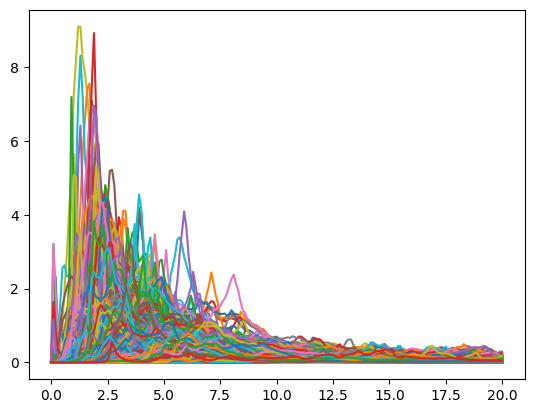

In [21]:
omega_interp = df.iloc[0].energies_interp

for i in range(len(df)):
    plt.plot(omega_interp,df.data.iloc[i].y.reshape(-1))
plt.show()

In [12]:
# df.to_pickle("../dataset/ready2train.pkl")

In [13]:
# test = pd.read_pickle("../dataset/ready2train.pkl")
# test.head()

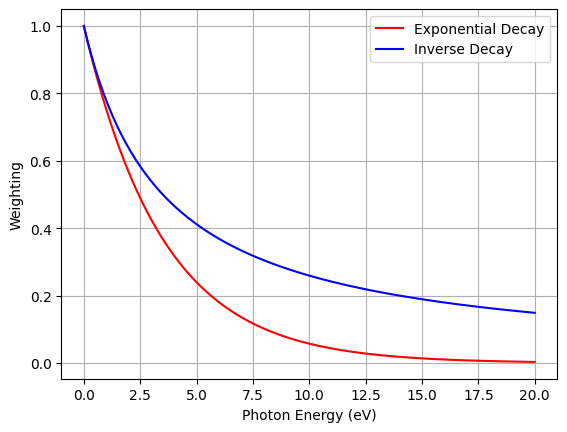

In [14]:
import torch
import matplotlib.pyplot as plt

energy_grid = torch.linspace(0, 20, steps=201)  # (201,)
lambda_decay = 3.5 # Decay rate in eV
weighting = torch.exp(-energy_grid / lambda_decay)  # Smoothly decays with energy


lambda_decay = 3.5
inv_deacy_weighting = 1 / (1 + energy_grid / lambda_decay)
plt.plot(energy_grid.cpu().numpy(), weighting.cpu().numpy(),color="red",label="Exponential Decay")
plt.plot(energy_grid.cpu().numpy(), inv_deacy_weighting.cpu().numpy(),color='blue',label="Inverse Decay")

plt.xlabel(r"Photon Energy (eV)")
plt.ylabel(r"Weighting")
plt.legend()
plt.grid()
plt.show()

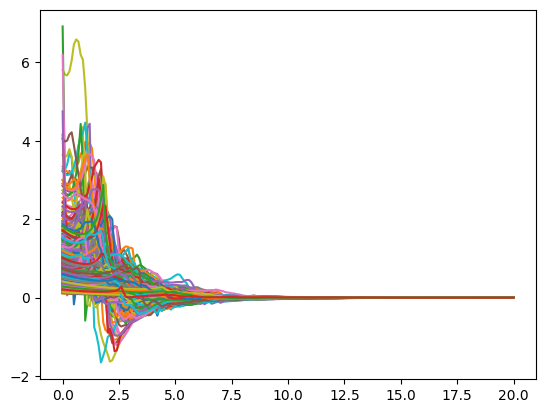

In [15]:
omega_interp = df.iloc[0].energies_interp
weight_broadcast = weighting.view(1, -1)  # Reshape for broadcasting (1, 201)

for i in range(len(df)):
    plt.plot(omega_interp, (df.data.iloc[i].y.reshape(-1) * weight_broadcast).squeeze(0))
plt.show()

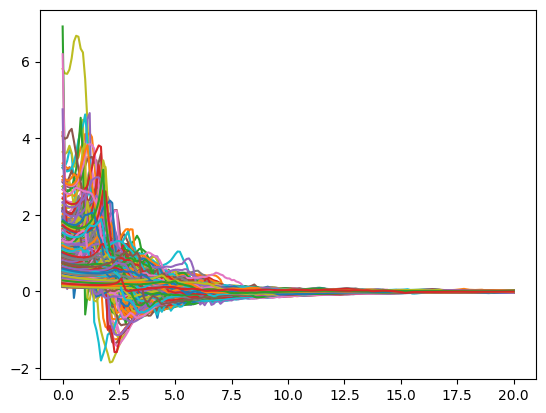

In [16]:
omega_interp = df.iloc[0].energies_interp
inv_weight_broadcast = inv_deacy_weighting.view(1, -1)  # Reshape for broadcasting (1, 201)

for i in range(len(df)):
    plt.plot(omega_interp, (df.data.iloc[i].y.reshape(-1) * inv_weight_broadcast).squeeze(0))
plt.show()